# Statistical Exploratory Data Analysis
### Earthquake magnitude distribution in California from 1966 to 2022 (57 years) (extract from the ANSS catalog).
The  data exploration stage develops the initial understanding of the data it involves employing statistical methods to summarise variables, detect trends, and establish correlations between these trends with those of other variables. A crucial aspect of this study is understanding the universal characteristics of earthquake data. The goal of the EDA is to identify precursor patterns and trends that can provide insights into the behaviour of seismic events.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns


In [3]:
df = pd.read_csv("earthquake data.csv", parse_dates=["DateTime"])

In [4]:
#Calculating b-value with MLE
max_magnitude = df['Magnitude'].max()
print("Maximum Magnitude (⟨M⟩):", max_magnitude)
# Calculate the average magnitude (⟨M⟩)
average_magnitude = np.mean(df['Magnitude'])

# Minimum magnitude (Mmin)
min_magnitude = min(df['Magnitude'])

# Calculate the b-value
b_value = np.log10(np.e) / (average_magnitude - min_magnitude)

# Print the result
print("Average Magnitude (⟨M⟩):", average_magnitude)
print("Minimum Magnitude (Mmin):", min_magnitude)
print("b-Value calculated using maximum likelihood:", b_value)
print("(⟨M⟩ - Mmin)",average_magnitude - min_magnitude)


Maximum Magnitude (⟨M⟩): 7.2
Average Magnitude (⟨M⟩): 2.9551765588406047
Minimum Magnitude (Mmin): 2.5
b-Value calculated using maximum likelihood: 0.9541231275385922
(⟨M⟩ - Mmin) 0.4551765588406047


### Earthquake magnitude distribution, with cumulative $\text{N}(>\text{M})$ and discrete $\text{N}(\text{M})$ distribution of magnitude

This explores the frequency distribution of earthquake magnitude to investigate if the dataset obeys the power law distribution and to calculate the b-value from the Gutenberg Richter formula on the California dataset.

\begin{equation} 
   
\log \text{N}(>\text{M})=\text{a}-\text{bM}    
\end{equation}

Histogram bin counts: This is an array containing the number of data points that fall within each bin of the histogram.
Bin edges: These are the values that define the boundaries of each bin in the histogram. The first element in the edges array represents the lower limit of the first bin, the second element represents the upper limit of the first bin, and so on. Essentially, the bin edges create the bins that the data points are counted within.

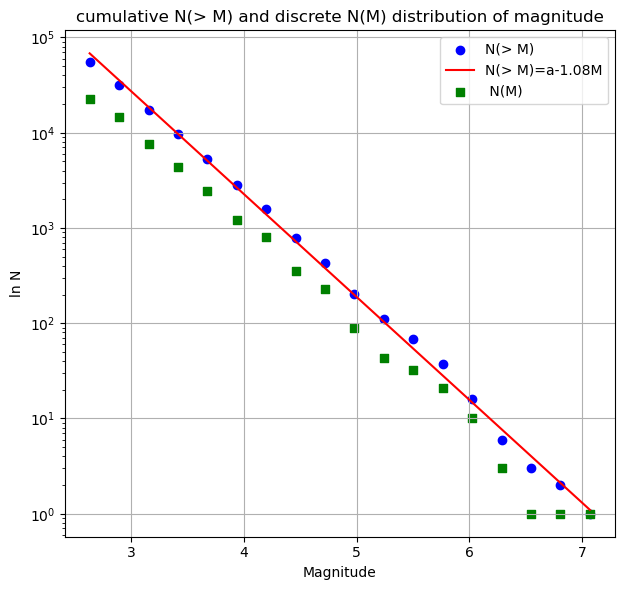

Slope (b-value): 1.079550586984792
Parameter a (intercept): 7.6732978141975146


In [5]:


def calculate_histogram(df, num_bins=18, min_mag=min_magnitude, max_mag=max_magnitude):
    # Calculate the histogram
    hist, edges = np.histogram(df['Magnitude'], bins=num_bins, range=(min_mag, max_mag))
    return hist, edges

def calculate_cumulative_histogram(hist):
    # Calculate the cumulative histogram
    cumulative_hist = np.cumsum(hist[::-1])[::-1] #calculated right-to-left then flipped back so bin order is preserved
    log_cumulative_hist = np.log10(cumulative_hist)
    return log_cumulative_hist

def calculate_magnitude_bins(edges):
    # Calculate the midpoints of the bins
    magnitude_bins = (edges[:-1] + edges[1:]) / 2
    return magnitude_bins

def calculate_linear_regression(magnitude_bins, log_cumulative_hist):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(magnitude_bins, log_cumulative_hist)
    return slope, intercept

def plot_histogram_and_regression(magnitude_bins, log_cumulative_hist, log_hist):
    # Plot both in a single figure
    plt.figure(figsize=(12, 6))

    # Log Cumulative N(> M) plot plt.loglog
    plt.subplot(1, 2, 1)
    plt.scatter(magnitude_bins, 10**log_cumulative_hist, marker='o', label="N(> M)", color='blue')
    plt.plot(magnitude_bins, 10**(slope * magnitude_bins + intercept), color='red', label=f'N(> M)=a-{abs(slope):.2f}M')
    plt.scatter(magnitude_bins, 10**log_hist, marker='s', label=" N(M)", color='green')
    plt.xlabel('Magnitude')
    plt.ylabel('ln N')
    plt.title('cumulative N(> M) and discrete N(M) distribution of magnitude')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def print_regression_parameters(slope, intercept):
    # Print results
    print("Slope (b-value):", -slope)
    print("Parameter a (intercept):", intercept)

# Main code
hist, edges = calculate_histogram(df)
log_cumulative_hist = calculate_cumulative_histogram(hist)
magnitude_bins = calculate_magnitude_bins(edges)
slope, intercept = calculate_linear_regression(magnitude_bins, log_cumulative_hist)
log_hist = np.log10(hist)  # Logarithm of histogram
plot_histogram_and_regression(magnitude_bins, log_cumulative_hist, log_hist)
print_regression_parameters(slope, intercept)



The frequency magnitude distribution of GR-law. Cumulative $\text{N}(>\text{M})$ is represented by the blue data points and the probability distribution $\text{N}(\text{M})$ is represented by the green data points of the Earthquake dataset. The red line is the line of best fit using least square regression.
One observation of the data in figure is that earthquake events adhere to power-law distributions and are linear on a log-log scale. The size distribution of the events is characterised by the exponent, b-value. Substantial variations are noted in the b-value and the shape of the distribution for the largest events referred to as the tail shape of the event size distribution (power law). The tail shape of the event size distribution is of particular interest. It represents the distribution of the largest events, which often have the most impacts in terms of damage and societal consequences.

### Comparing the Cumulative Distribution Function ($\text{cdf}$) and the Probability Density Function also known as discrete ($\text{pdf}$), $N(>E)$ 

To determine the magnitude M using the Gutenberg Richter relationship between magnitude and energy for $\text{M} \leq8$ . Here the term $7.67$ is derived from the Gutenberg-Richter(t) Scaling Law which is the intercept parameter a.

$$

    
\begin{align}
\text{log E} &= 1.5 \text{M} + 7.67  \\
\text{M} &= \frac{2}{3} \log E - 7.67 
\end{align}

$$

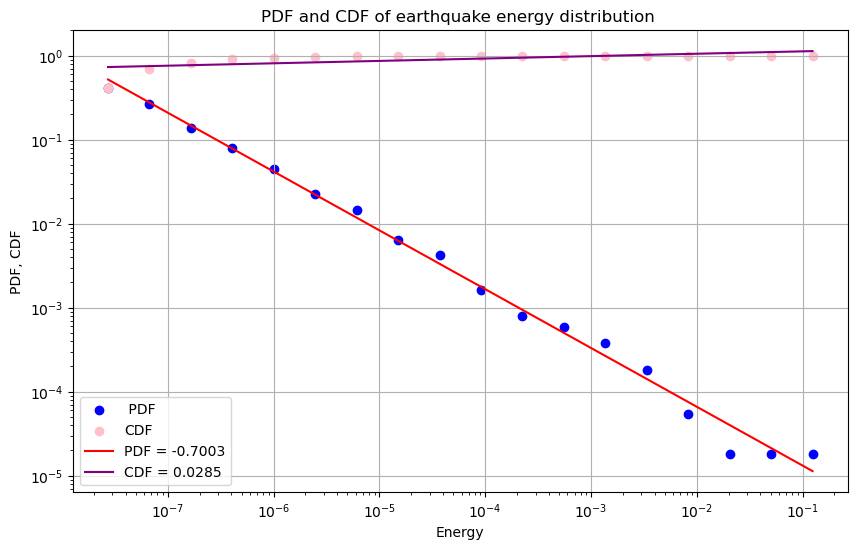

PDF Slope: -0.7003124820290786
CDF Slope: 0.0284659051503654


In [6]:

def calculate_energy(magnitude_bins, intercept):
    """Calculate energy from magnitude bins."""
    energy = 10**((3/2) * (magnitude_bins - intercept))
    return energy

def calculate_pdf(hist, edges):
    """Calculate PDF from histogram."""
    pdf = hist / np.diff(edges)
    return pdf

def normalize_pdf(pdf):
    """Normalize PDF."""
    normalized_pdf = pdf / np.sum(pdf)
    return normalized_pdf

def calculate_cdf(normalized_pdf):
    """Calculate CDF from normalized PDF."""
    cdf = np.cumsum(normalized_pdf)
    return cdf

def plot_energy_pdf_and_cdf(energy, normalized_pdf, cdf, pdf_regression_line, cdf_regression_line):
    """Plot Energy vs. Normalized PDF and CDF along with regression lines."""
    plt.figure(figsize=(10, 6))
    plt.scatter(energy, normalized_pdf, marker='o', color='blue', label=' PDF')
    plt.scatter(energy, cdf, marker='o', color='pink', label='CDF')

    # Linear regression for PDF
    plt.plot(energy, pdf_regression_line, color='red', label=f'PDF = {pdf_slope:.4f}')

    # Linear regression for CDF
    plt.plot(energy, cdf_regression_line, color='purple', label=f'CDF = {cdf_slope:.4f}')

    plt.xlabel('Energy')
    plt.ylabel('PDF, CDF')
    plt.title('PDF and CDF of earthquake energy distribution ')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()

    plt.show()

def print_regression_parameters(pdf_slope, cdf_slope):
    """Print regression slopes."""
    print("PDF Slope:", pdf_slope)
    print("CDF Slope:", cdf_slope)

# Main code
energy = calculate_energy(magnitude_bins, intercept)
pdf = calculate_pdf(hist, edges)
normalized_pdf = normalize_pdf(pdf)
cdf = calculate_cdf(normalized_pdf)

# Linear regression for PDF
pdf_slope, pdf_intercept, _, _, _ = linregress(np.log(energy), np.log(normalized_pdf))
pdf_regression_line = np.exp(pdf_intercept) * (energy ** pdf_slope)

# Linear regression for CDF
cdf_slope, cdf_intercept, _, _, _ = linregress(np.log(energy), np.log(cdf))
cdf_regression_line = np.exp(cdf_intercept) * (energy ** cdf_slope)

plot_energy_pdf_and_cdf(energy, normalized_pdf, cdf, pdf_regression_line, cdf_regression_line)
print_regression_parameters(pdf_slope, cdf_slope)


Variations in the power law shape and tail are shown to be related to the presence of an exponential cut-off that depends on the finite size of the model and diverges as the
critical point is approached.

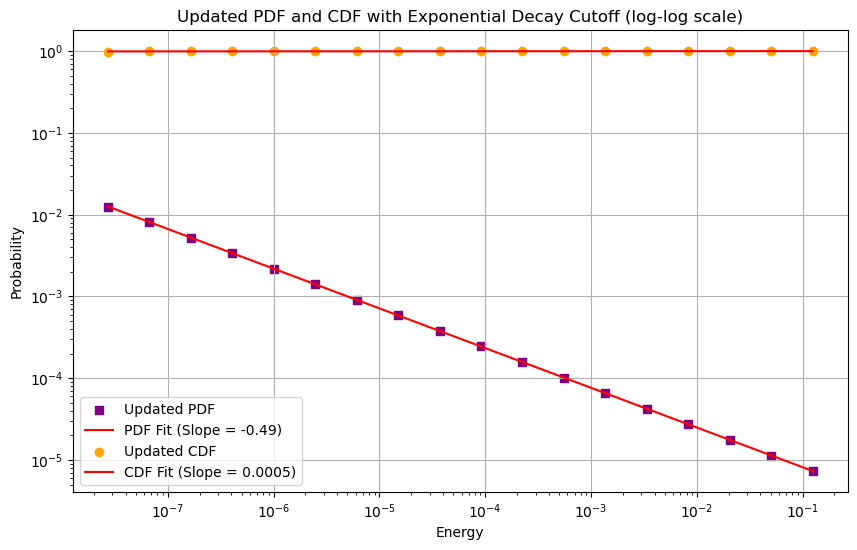

In [7]:


def calculate_updated_pdf(magnitude_bins, beta, s_0):
    """Calculate updated PDF based on the formulas."""
    pdf_updated = magnitude_bins**(-beta-1) * np.exp(-magnitude_bins/s_0)
    return pdf_updated

def fit_line_to_pdf(energy, pdf_updated):
    """Fit a line to the updated PDF."""
    pdf_slope, pdf_intercept, _, _, _ = linregress(np.log(energy), np.log(pdf_updated))
    pdf_fit_line = np.exp(pdf_intercept) * (energy ** pdf_slope)
    return pdf_slope, pdf_fit_line

def calculate_updated_cdf(magnitude_bins, s_0):
    """Calculate updated CDF based on the formulas."""
    cdf_updated = 1 - np.exp(-magnitude_bins/s_0)
    return cdf_updated

def fit_line_to_cdf(energy, cdf_updated):
    """Fit a line to the updated CDF."""
    cdf_slope, cdf_intercept, _, _, _ = linregress(np.log(energy), np.log(cdf_updated))
    cdf_fit_line = np.exp(cdf_intercept) * (energy ** cdf_slope)
    return cdf_slope, cdf_fit_line

def plot_updated_pdf_cdf(energy, pdf_updated, pdf_fit_line, cdf_updated, cdf_fit_line, pdf_slope, cdf_slope):
    """Create a log-log plot for the updated PDF and CDF."""
    plt.figure(figsize=(10, 6))
    # Updated PDF
    plt.scatter(energy, pdf_updated, marker='s', label='Updated PDF', color='purple')
    plt.plot(energy, pdf_fit_line, color='red', label=f'PDF Fit (Slope = {pdf_slope:.2f})')
    # Updated CDF
    plt.scatter(energy, cdf_updated, marker='o', label='Updated CDF', color='orange')
    plt.plot(energy, cdf_fit_line, color='red', label=f'CDF Fit (Slope = {cdf_slope:.4f})')
    plt.xlabel('Energy')
    plt.ylabel('Probability')
    plt.title('Updated PDF and CDF with Exponential Decay Cutoff (log-log scale)')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.legend()
    plt.grid()
    plt.show()

# Main code
# Parameters
beta = slope
s_0 = 0.59 # Cutoff size
pdf_updated = calculate_updated_pdf(magnitude_bins, beta, s_0)
pdf_slope, pdf_fit_line = fit_line_to_pdf(energy, pdf_updated)
cdf_updated = calculate_updated_cdf(magnitude_bins, s_0)
cdf_slope, cdf_fit_line = fit_line_to_cdf(energy, cdf_updated)
plot_updated_pdf_cdf(energy, pdf_updated, pdf_fit_line, cdf_updated, cdf_fit_line, pdf_slope, cdf_slope)


Cut-off exists for the largest events and the completeness magnitude ($\text{M}_\text{c}$), $\text{M}_\text{c}$=2.6. The power law trend of the ${pdf}$ appears only between the completeness level, for the smallest events, and the cut-off, for the largest event. The fit function tells us that the exponential behaviour is muted, as it is not present in the plot.

### Temporal evolution of a & b-values using the least square method.

The moving windows algorithm is used  to find the temporal value of b(t) and a(t), the window size specifies the number of earthquake events considered in each section of the rolling analysis. The step size defines the number of steps between each window, it determines how much the window moves forward for each iteration. This extracts the temporal evolution of how the b-value changes. A  large number of events (1000) is allocated in moving windows to allow for an accurate estimation of the b-value regarding the sampling bias and step size of 500.

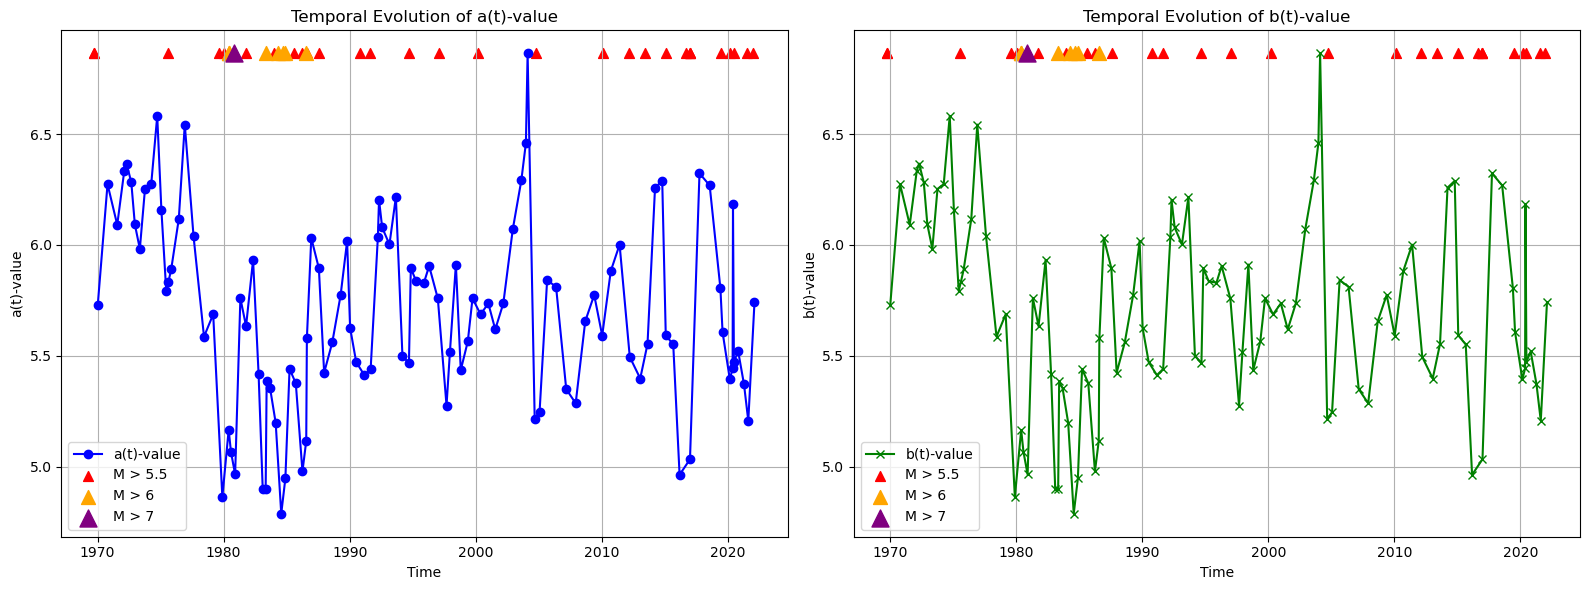

In [8]:
from scipy.stats import linregress
# Define a function to calculate the a-value using least squares regression on log-transformed histogram data
earthquake_data = df
def calculate_parameters_least_squares(magnitudes):
    # Calculate histogram for the magnitudes in the window
    hist, edges = np.histogram(magnitudes, bins=18, range=(2.5, 7.2))
    cumulative_hist = np.cumsum(hist[::-1])[::-1]  # Cumulative histogram
    magnitude_bins = (edges[:-1] + edges[1:]) / 2  # Midpoints of the bins

    # Filtering out bins with zero counts to avoid log(0)
    valid_indices = cumulative_hist > 0
    log_cumulative_hist = np.log10(cumulative_hist[valid_indices])
    valid_magnitude_bins = magnitude_bins[valid_indices]

    # Perform linear regression on log-transformed data
    slope, intercept, _, _, _ = linregress(valid_magnitude_bins, log_cumulative_hist)
    return intercept

# Set window parameters
window_size = 1000
overlap = 500
# Calculate b-values for successive windows
b_values = []
start_indices = list(range(0, len(earthquake_data) - window_size, window_size - overlap))
for start in start_indices:
    window_data = earthquake_data.iloc[start:start+window_size]
    b_value = calculate_parameters_least_squares(window_data['Magnitude'])
    b_values.append(b_value)

# Calculate b-values for successive windows using least squares regression
b_values_least_squares = [calculate_parameters_least_squares(earthquake_data.iloc[start:start+window_size]['Magnitude']) for start in start_indices]

# Calculate a-values for successive windows using least squares regression
a_values_least_squares = [calculate_parameters_least_squares(earthquake_data.iloc[start:start+window_size]['Magnitude']) for start in start_indices]
# Extracting the mid-point time for each window to represent on the x-axis
mid_times = [earthquake_data.iloc[start + window_size // 2]['DateTime'] for start in start_indices]

# Identifying the times for earthquakes larger than magnitudes 5.5, 6, and 7
times_55 = earthquake_data[earthquake_data['Magnitude'] > 5.5]['DateTime']
times_6 = earthquake_data[earthquake_data['Magnitude'] > 6]['DateTime']
times_7 = earthquake_data[earthquake_data['Magnitude'] > 7]['DateTime']


# Creating side-by-side plots for a(t)-values and b(t)-values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting a(t)-values
ax1.plot(mid_times, a_values_least_squares, marker='o', linestyle='-', color='blue', label='a(t)-value')
ax1.scatter(times_55, [max(a_values_least_squares)]*len(times_55), marker='^', color='red', s=50, label='M > 5.5')
ax1.scatter(times_6, [max(a_values_least_squares)]*len(times_6), marker='^', color='orange', s=100, label='M > 6')
ax1.scatter(times_7, [max(a_values_least_squares)]*len(times_7), marker='^', color='purple', s=150, label='M > 7')
ax1.set_xlabel('Time')
ax1.set_ylabel('a(t)-value')
ax1.set_title('Temporal Evolution of a(t)-value')
ax1.grid(True)
ax1.legend()

# Plotting b(t)-values
ax2.plot(mid_times, b_values_least_squares, marker='x', linestyle='-', color='green', label='b(t)-value')
ax2.scatter(times_55, [max(b_values_least_squares)]*len(times_55), marker='^', color='red', s=50, label='M > 5.5')
ax2.scatter(times_6, [max(b_values_least_squares)]*len(times_6), marker='^', color='orange', s=100, label='M > 6')
ax2.scatter(times_7, [max(b_values_least_squares)]*len(times_7), marker='^', color='purple', s=150, label='M > 7')
ax2.set_xlabel('Time')
ax2.set_ylabel('b(t)-value')
ax2.set_title('Temporal Evolution of b(t)-value')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


Significant temporal variations of the b-value exist, as well as in the a-value. To validate if this decrease may be considered a precursor of large earthquakes, identification of the largest events consider using different magnitude thresholds ($M>7$, $M>6$, $M>5.5$). One may first observe that the $M>7$ event is  preceded by a substantial decrease in the b-value.
The rate of detection is good and the output can be considered as a promising method. But several times there is a decrease of the b-value without the occurrence of such a large event. When decreasing the threshold for large events to $M>6$, the rate of false alarms decreases but the rate of detection too. This effect is enhanced when considering events of $M>5.5$. 